In [1]:
import os
import copy
import glob
import pickle
import matplotlib
import collections
import brewer2mpl
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

bmap = brewer2mpl.get_map('Reds', 'Sequential', 9)

%matplotlib inline

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rcParams.update({'font.size':16})

In [2]:
def get_time_data(sim_dir):
    
    cell_count = []
    cell_speed_mean = []
    cell_speed_std = []
    foi = []
    num_cells_cluster = []
    cluster_size_mean = []
    cluster_size_std = []
    
    for itr in range(1, 2000):
        c_iter = str(itr*100).zfill(6)
        posMat = pd.read_csv(os.sep.join([sim_dir, 'Pos_'+c_iter+'.dat']), header=None)
        position = [complex(pos.replace('i','j')) for pos in posMat.values[0]]
        velMat = pd.read_csv(os.sep.join([sim_dir, 'Velocity_'+c_iter+'.dat']), header=None)
        velocity = list()
        
        for vel in velMat.values[0]:
            if repr(vel)=='0':
                velocity.append(complex('0+0j'))
            else:
                velocity.append(complex(vel.replace('i','j')))
        
        speed = [np.sqrt(np.real(vel)**2 + np.imag(vel)**2) for vel in velocity]
        cell_count.append(len(position))
        cell_speed_mean.append(np.mean(speed))
        cell_speed_std.append(np.std(speed))
        nbdMat = pd.read_csv(os.sep.join([sim_dir, 'Neighbors_'+c_iter+'.dat']), header=None)
        num_neighbors = [int(nbd) for nbd in nbdMat.values]
        foi.append(np.true_divide(len(np.where(np.asarray(num_neighbors)==0)[0]), len(num_neighbors)))
        num_cells_cluster.append(len(np.where(np.asarray(num_neighbors)>4)[0]))
        edges = None
        
        if os.path.getsize(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat'])) > 0:
            edgexMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat']), header=None)
            edgeyMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeY_'+c_iter+'.dat']), header=None)
            edges = zip(list(edgexMat[0]),list(edgexMat[1]),list(edgeyMat[0]),list(edgeyMat[1]))
    
    return (cell_count, cell_speed_mean, cell_speed_std, foi, num_cells_cluster)

def get_neighbor_vertices(xp, yp, num_neighbors, pos):
    
    deg = 0
    tol = 1e-12
    neighbor_vertices = []
    
    for ee in edg:
        
        if (np.abs(xp - ee[0]) < tol) and (np.abs(yp - ee[2]) < tol):
            
            dest_x = ee[1]
            dest_y = ee[3]
            if dest_x == 10.0:
                for pde in edg:
                    if (np.abs(-10.0 - pde[1]) < tol) and (np.abs(dest_y - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            if dest_x == -10.0:
                for pde in edg:
                    if (np.abs(10.0 - pde[1]) < tol) and (np.abs(dest_y - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            if dest_y == -10.0:
                for pde in edg:
                    if (np.abs(dest_x - pde[1]) < tol) and (np.abs(10.0 - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            if dest_y == 10.0:
                for pde in edg:
                    if (np.abs(dest_x - pde[1]) < tol) and (np.abs(-10.0 - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            
            idx_dest_x = np.where(np.abs(np.real(pos) - dest_x) < tol)[0]
            idx_dest_y = np.where(np.abs(np.imag(pos) - dest_y) < tol)[0]
            
            if len(idx_dest_x) == 1 and len(idx_dest_y) == 1:
                if idx_dest_x[0] == idx_dest_y[0]:
                    neighbor_vertices.append(idx_dest_x[0])
                    deg = deg + 1
            else:
                if len(idx_dest_x) > 0 and len(idx_dest_y) > 0:
                    res = list(set(idx_dest_x).intersection(set(idx_dest_y)))
                    if len(res) == 1:
                        neighbor_vertices.append(res[0])
                        deg = deg + 1
                    else:
                        #print "Did not work"
                        #print idx_dest_x
                        #print idx_dest_y
                        print ""
                else:
                    #print "Did not work"
                    #print idx_dest_x
                    #print idx_dest_y
                    print ""
                    
    #print(num_neighbors, deg) 
    
    if (num_neighbors != deg):
        print "Something went horribly wrong"
        
    return neighbor_vertices

def get_frame_data(sim_dir, itr):
    
    c_iter = str(itr*100).zfill(6)
    posMat = pd.read_csv(os.sep.join([sim_dir, 'Pos_'+c_iter+'.dat']), header=None)
    position = [complex(pos.replace('i','j')) for pos in posMat.values[0]]
    velMat = pd.read_csv(os.sep.join([sim_dir, 'Velocity_'+c_iter+'.dat']), header=None)
    velocity = list()
    for vel in velMat.values[0]:
        if repr(vel)=='0':
            velocity.append(complex('0+0j'))
        else:
            velocity.append(complex(vel.replace('i','j')))
    nbdMat = pd.read_csv(os.sep.join([sim_dir, 'Neighbors_'+c_iter+'.dat']), header=None)
    num_neighbors = [int(nbd) for nbd in nbdMat.values]
    edges = None
    
    if os.path.getsize(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat'])) > 0:
        edgexMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat']), header=None)
        edgeyMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeY_'+c_iter+'.dat']), header=None)
        edges = zip(list(edgexMat[0]),list(edgexMat[1]),list(edgeyMat[0]),list(edgeyMat[1]))
        
    return (position, velocity, num_neighbors, edges)

def visualize_frame(sim_dir, itr, disp):
    
    itr_s = str(itr).zfill(4)
    data = get_frame_data(sim_dir, itr)
    position = data[0]
    velocity = data[1]
    num_neighbors = data[2]
    edges = data[3]
    cdata = list()
    for nbd in num_neighbors:
        if nbd == 0:
            cdata.append('indianred')
        elif nbd < 4:
            cdata.append('royalblue')
        else:
            cdata.append('seagreen')
    plt.figure(figsize=(2,2), dpi=200)
    plt.scatter(np.real(position), np.imag(position), color=cdata, s=8)
    if edges is not None:
        for e in edges:
            plt.plot([e[0], e[1]], [e[2], e[3]], marker=None, linewidth=0.75, color='gray', alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10.1, 10.1])
    plt.ylim([-10.1, 10.1])
    
    if disp:
        plt.show()
    else:
        plt.savefig(sim_dir+'_plots'+os.sep+itr_s+'.png', bbox_inches='tight')
        
def save_frame(sim_dir, itr, name):
    
    itr_s = str(itr).zfill(4)
    data = get_frame_data(sim_dir, itr)
    position = data[0]
    velocity = data[1]
    num_neighbors = data[2]
    edges = data[3]
    cdata = list()
    
    for nbd in num_neighbors:
        if nbd == 0:
            cdata.append('indianred')
        elif nbd < 4:
            cdata.append('royalblue')
        else:
            cdata.append('seagreen')
    
    plt.figure(figsize=(2,2), dpi=600)
    plt.rcParams["axes.grid"] = True
    plt.scatter(np.real(position), np.imag(position), color=cdata, s=8)
    if edges is not None:
        for e in edges:
            plt.plot([e[0], e[1]], [e[2], e[3]], marker=None, linewidth=0.75, color='gray', alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10.1, 10.1])
    plt.ylim([-10.1, 10.1])
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    plt.savefig(name, bbox_inches='tight', transparent=True)

In [14]:
###### replicates = ['adh_pol_sweep/1_adh_5_pol', 'revision/1_adh_5_pol_rep2']

replicates = ['adh_pol_sweep/1_adh_5_pol', 'revision/1_adh_5_pol_rep3', 'revision/1_adh_5_pol_rep4']

Rgy = list()
csize = list()
frame_list = list()

for rep in replicates:
    
    for itr in range(50, 700):

        (pos, vel, nn, edg) = get_frame_data(rep, itr)

        graphs = list()
        marked_vertices = np.zeros(len(pos))

        for ppi in range(len(pos)):

            if marked_vertices[ppi] == 1:
                continue

            pp = pos[ppi]

            xp = np.real(pp)
            yp = np.imag(pp)
            num_neighbors = nn[ppi]

            #print(xp, yp)
            graph = []
            graph.append(pp)
            marked_vertices[ppi] = 1

            neighbor_vertices = get_neighbor_vertices(xp, yp, num_neighbors, pos)

            while(len(neighbor_vertices) != 0):

                vert = neighbor_vertices.pop(0)
                if marked_vertices[vert] == 1:
                    continue
                graph.append(pos[vert])
                marked_vertices[vert] = 1

                xnp = np.real(pos[vert])
                ynp = np.imag(pos[vert])
                num_neighbors_p = nn[vert]
                next_neighbors = get_neighbor_vertices(xnp, ynp, num_neighbors_p, pos)

                for n_vert in next_neighbors:
                    if marked_vertices[n_vert] == 1:
                        continue
                    else:
                        neighbor_vertices.append(n_vert)

            graphs.append(graph)

        num_clusters = 0

        for gc in range(len(graphs)):

            g = graphs[gc]

            xp = np.real(g)
            yp = np.imag(g)

            cluster_size = len(xp)

            prev_xCOM = None
            prev_yCOM = None
            diff_COM = None

            while (diff_COM == None or diff_COM > 0.1):

                xCOM = np.true_divide(np.sum(xp), cluster_size)
                yCOM = np.true_divide(np.sum(yp), cluster_size)
                xnew = xp - xCOM
                ynew = yp - yCOM

                for ii in range(len(xnew)):
                    if xnew[ii] < -10:
                        xnew[ii] = 20.0 + xnew[ii]
                    if xnew[ii] > 10:
                        xnew[ii] = xnew[ii] - 20.0

                for ii in range(len(ynew)):
                    if ynew[ii] < -10:
                        ynew[ii] = 20.0 + ynew[ii]
                    if ynew[ii] > 10:
                        ynew[ii] = ynew[ii] - 20.0

                prev_xCOM = xCOM
                prev_yCOM = yCOM
                xCOM = np.true_divide(np.sum(xnew), cluster_size)
                yCOM = np.true_divide(np.sum(ynew), cluster_size)
                diff_COM = np.sqrt((xCOM-prev_xCOM)**2 + (yCOM-prev_yCOM)**2)
                xp = xnew
                yp = ynew

            Rgy_Sq = 0.0
            for (xpp, ypp) in zip(xnew, ynew):
                Rgy_Sq += (xpp-xCOM)**2 + (ypp-yCOM)**2
            Rgy_Sq = Rgy_Sq * np.true_divide(1, cluster_size)

            if cluster_size >= 4:

                num_clusters += 1

                if np.sqrt(Rgy_Sq) > 7.0:
                    #print 'Itr: ' + repr(itr)
                    continue

                Rgy.append(np.sqrt(Rgy_Sq))
                csize.append(cluster_size)
                frame_list.append(itr)

        #print 'Itr: ' + repr(itr) + ' Number of clusters: ' + repr(num_clusters)

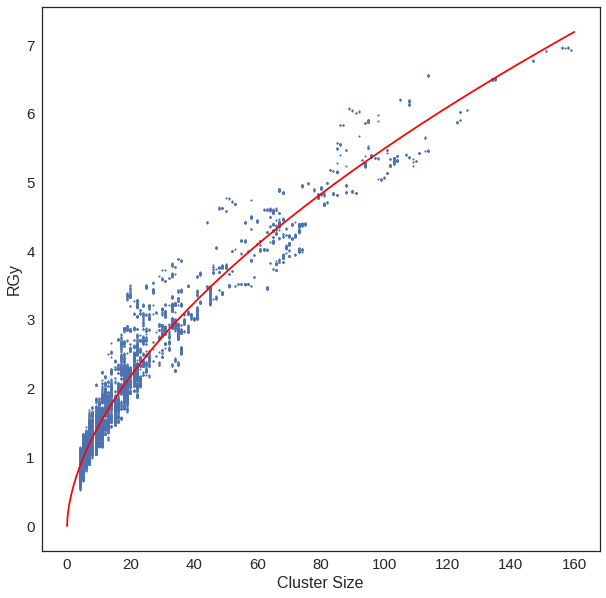

In [22]:
sns.set_style("white")
plt.figure(figsize=(10,10))

plt.scatter(csize, Rgy, s=3)

xs = np.linspace(0, 160, 1000)
ys = 0.3902550*xs**0.5741333
plt.plot(xs, ys, c='red')

plt.xlabel('Cluster Size', size=16)
plt.ylabel('RGy', size=16)

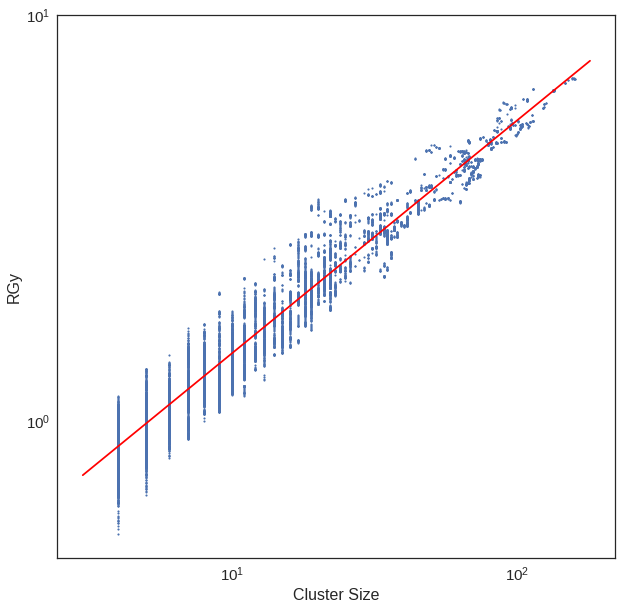

In [23]:
plt.figure(figsize=(10,10))

plt.scatter(csize, Rgy, s=3)

xs = np.linspace(3, 180, 1000)
ys = 0.3902550*xs**0.5741333
plt.plot(xs, ys, c='red')

plt.xlabel('Cluster Size', size=16)
plt.ylabel('RGy', size=16)

plt.xscale("log")
plt.yscale("log")
plt.yticks([1, 10]);

In [20]:
np.save("ABM_Spanning_RGy.npy", Rgy)
np.save("ABM_Spanning_CS.npy", csize)

In [24]:
1/0.5741333

1.741755790859022

In [21]:
sio.savemat('ABM_Spanning_FD.mat', {'csize':csize, 'RGy':Rgy})